In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import glob
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.
C:\Users\zhajr\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\zhajr\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\zhajr\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\zhajr\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
files=glob.glob('../stock-data-dow-jones/*.csv')
#files=glob.glob('stock-data-dow-jones/*.txt')
df = pd.read_csv(files[14],index_col = 0)

In [3]:
df['log_return'] = [0.0]*df.shape[0]
for i in range(1,df.shape[0]):
    df['log_return'][i]=np.log(df['close'][i]/df['close'][i-1])*100

C:\Users\zhajr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
df.head()

,open,high,low,close,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime,log_return
date,,,,,,,,,,,,
2014-06-12,34.6187,34.8500,34.5845,34.6273,11583569,11583569,-0.115636,-0.333,34.7113,"Jun 12, 14",0.000000,0.000000
2014-06-13,34.6016,34.7258,34.4817,34.5845,9203771,9203771,-0.042836,-0.124,34.5761,"Jun 13, 14",-0.001236,-0.123678
2014-06-16,34.4303,34.9271,34.3960,34.8329,12878160,12878160,0.248441,0.718,34.8076,"Jun 16, 14",0.005938,0.715674
2014-06-17,35.2784,35.2955,34.7901,35.0556,26927159,26927159,0.222738,0.639,35.0595,"Jun 17, 14",0.012369,0.637303
2014-06-18,34.9443,35.6125,34.9100,35.6039,18518178,18518178,0.548282,1.564,35.3470,"Jun 18, 14",0.028203,1.551981


In [6]:
df['volatility']=np.log(np.sqrt(pow((df['log_return']-df['log_return'].mean()),2)))

In [15]:
#df['volatility']=pow(df['log_return'],2)

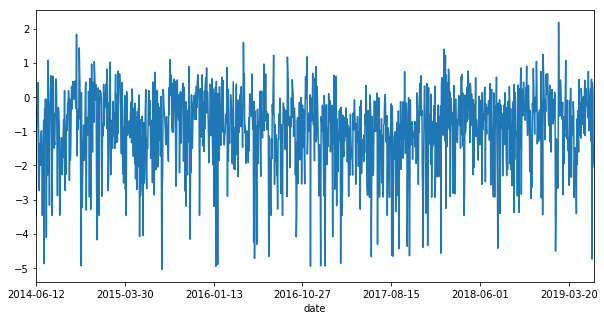

In [7]:
plt.figure(figsize = (10,5))
fg = df.volatility.plot()

In [17]:
'''
df_train = df['volatility'][df.index < "2017-03-01"]

df_val = df['volatility'][(df.index >= "2017-03-01") & (df.index < "2018-05-01")]

df_test = df['volatility'][df.index >= "2018-05-01"]

df_train = np.array(df_train).reshape(-1,1)
df_val = np.array(df_val).reshape(-1,1)
df_test = np.array(df_test).reshape(-1,1)
'''

'\ndf_train = df[\'volatility\'][df.index < "2017-03-01"]\n\ndf_val = df[\'volatility\'][(df.index >= "2017-03-01") & (df.index < "2018-05-01")]\n\ndf_test = df[\'volatility\'][df.index >= "2018-05-01"]\n\ndf_train = np.array(df_train).reshape(-1,1)\ndf_val = np.array(df_val).reshape(-1,1)\ndf_test = np.array(df_test).reshape(-1,1)\n'

In [8]:
# normalize the dataset
scaler1 = MinMaxScaler(feature_range=(0, 1))
df_x = np.array(df.volatility).reshape(-1,1)
df_x = scaler1.fit_transform(df_x)

scaler2 = MinMaxScaler(feature_range=(0, 1))
df_y = np.array(df.volatility).reshape(-1,1)
df_y = scaler2.fit_transform(df_y)

In [9]:
def create_dataset(df_x, df_y, look_back=1):
    dataX, dataY = [], []
    for i in range(len(df)-look_back):
        a = df_x[i:(i+look_back)]
        dataX.append(a)
        dataY.append(df_y[i+look_back])
    return np.array(dataX), np.array(dataY)
look_back = 10
data_X, data_Y = create_dataset(df_x, df_y, look_back)

In [10]:
data_X.shape

(1248, 10, 1)

In [11]:
# split into train and test sets
train_size = (int(len(df_y ) * 0.8) // 100) * 100
test_size = ((len(df_y) - train_size) // 100) * 100
df_x = df_x[:train_size+test_size]
df_y = df_y[:train_size+test_size]
data_X = data_X[:train_size+test_size]
data_Y = data_Y[:train_size+test_size]
trainX, testX = data_X[0:train_size], data_X[train_size:train_size + test_size]
trainY, testY = data_Y[0:train_size], data_Y[train_size:train_size + test_size]
trainX.shape

(1000, 10, 1)

In [12]:
# reshape input to be [samples, time steps, features]
trainX = trainX.reshape((-1, look_back, 1))
testX = testX.reshape( (-1, look_back, 1))
trainY = trainY.reshape((-1, 1))
testY = testY.reshape( (-1, 1))


In [13]:
testX.shape

(200, 10, 1)

In [14]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, activation='tanh', input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(50, activation='relu', input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(25, activation='relu', input_shape=(look_back, 1), return_sequences=False))
#model.add(LSTM(20, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, epochs=30, verbose=1)


Epoch 1/30
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1079
Epoch 2/30
1000/1000 [==============================] - 0s 418us/step - loss: 0.0275
Epoch 3/30
1000/1000 [==============================] - 0s 426us/step - loss: 0.0263
Epoch 4/30
1000/1000 [==============================] - 0s 423us/step - loss: 0.0265
Epoch 5/30
1000/1000 [==============================] - 0s 486us/step - loss: 0.0261
Epoch 6/30
1000/1000 [==============================] - 0s 426us/step - loss: 0.0269
Epoch 7/30
1000/1000 [==============================] - 0s 425us/step - loss: 0.0261
Epoch 8/30
1000/1000 [==============================] - 0s 433us/step - loss: 0.0267
Epoch 9/30
1000/1000 [==============================] - 0s 426us/step - loss: 0.0262
Epoch 10/30
1000/1000 [==============================] - 0s 479us/step - loss: 0.0263
Epoch 11/30
1000/1000 [==============================] - 0s 440us/step - loss: 0.0267
Epoch 12/30
1000/1000 [==============================] - 1s 637u

In [15]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler2.inverse_transform(trainPredict)

trainY = scaler2.inverse_transform(trainY)
testPredict = scaler2.inverse_transform(testPredict)
testY = scaler2.inverse_transform(testY)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print('R^2 train: %.3f' % (r2_score(trainY, trainPredict[:,0])))
print('R^2 test: %.3f' % (r2_score(trainY, trainPredict[:,0])))

Train Score: 1.16 RMSE
Test Score: 1.10 RMSE
R^2 train: -0.003
R^2 test: -0.003


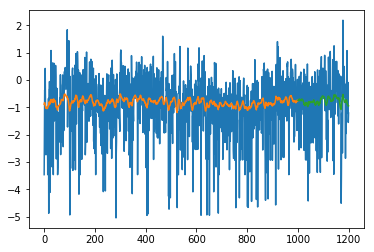

In [16]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_x)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[0:len(trainPredict), :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_x)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict):len(df_x), :] = testPredict
# plot baseline and predictions
#plt.figure(figsize=(100,5))
plt.plot(scaler2.inverse_transform(df_y))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
#plt.plot(df.log_return)
plt.show()